# Music Genre Classification using CNN (Transfer learning with VGG16)

In [1]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import random
import cv2
import json
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc

from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.contrib.keras import optimizers
from tensorflow.contrib.keras import callbacks
from tensorflow.contrib.keras import regularizers
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
img_dir = 'spectrogram_images/'
img_height = 120
img_width = 120
num_classes = 10
num_epochs = 3
batch_size = 16
L2_lambda = 0.001

In [3]:
label_dict = {'blues':0,
              'classical':1,
              'country':2,
              'disco':3,
              'hiphop':4,
              'jazz':5,
              'metal':6,
              'pop':7,
              'reggae':8,
              'rock':9
             }

# Creating list of all file names
files = os.listdir('spectrogram_images/')

# converting images into arrays
files_data = []
# loop over the input images
for imagePath in files:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread('spectrogram_images/'+imagePath)
    image = cv2.resize(image, (img_height, img_width))
    image = img_to_array(image)
    files_data.append(image)

# Error might occur because of .ipynb checkpoints folder within the spectrogram_images folder: Delete it!
    
## Define and compute label array
label_array = []

# Extract the class label from the image path and update the labels list
directory = os.fsencode('spectrogram_images/')
   # iterate through root path
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    label = filename.split('.')[0]
    label_array.append(label)

    
# One Hot encode the integer encoded labels
ohe = OneHotEncoder(sparse=False)
label_array = np.array(label_array)
label_array = label_array.reshape(len(label_array), 1)
label_onehot_encoded = ohe.fit_transform(label_array) 
print(label_onehot_encoded.shape)
    
files_data = np.array(files_data)

# train test split of the files
train_files, test_files, train_labels, test_labels = train_test_split(files_data, label_onehot_encoded, random_state=42, test_size=0.1) # stratify=label_onehot_encoded.argmax(axis=1))

(1000, 10)


In [4]:
# Check how classes in test-split are distributed
test_labels.argmax(axis=1)
unique, counts = np.unique(test_labels.argmax(axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 14, 1: 11, 2: 9, 3: 9, 4: 7, 5: 12, 6: 9, 7: 8, 8: 12, 9: 9}

In [5]:
#Define Model
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(120,120,3)))
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

#Compile
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 116, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 58, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 58, 58, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 215296)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               27558016  
_________________________________________

In [6]:
#Train and Test The Model
history = model2.fit(train_files, train_labels, batch_size=4, epochs=20, verbose=1, validation_data=(test_files, test_labels))

Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - 18s 19ms/sample - loss: 97.2836 - acc: 0.1089 - val_loss: 2.2750 - val_acc: 0.1300
Epoch 2/20
900/900 [==============================] - 17s 19ms/sample - loss: 2.3059 - acc: 0.1111 - val_loss: 2.3046 - val_acc: 0.0600
Epoch 3/20
900/900 [==============================] - 17s 19ms/sample - loss: 2.3010 - acc: 0.1322 - val_loss: 2.3067 - val_acc: 0.1000
Epoch 4/20
900/900 [==============================] - 17s 19ms/sample - loss: 2.3264 - acc: 0.1056 - val_loss: 2.3067 - val_acc: 0.0700
Epoch 5/20
900/900 [==============================] - 17s 19ms/sample - loss: 2.3024 - acc: 0.0989 - val_loss: 2.3066 - val_acc: 0.0700
Epoch 6/20
900/900 [==============================] - 17s 19ms/sample - loss: 2.3026 - acc: 0.1156 - val_loss: 2.3068 - val_acc: 0.0700
Epoch 7/20
900/900 [==============================] - 17s 19ms/sample - loss: 2.3022 - acc: 0.0989 - val_loss: 2.3068 - val_acc: 0.0800
E

In [9]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

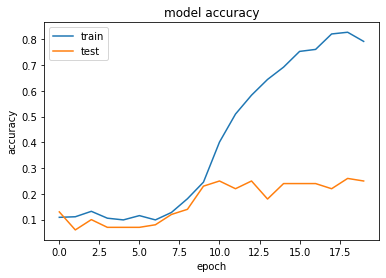

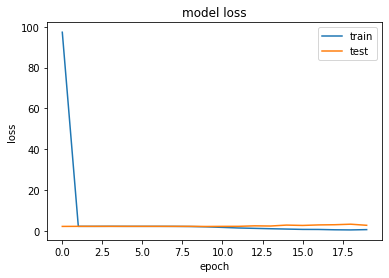

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [11]:
model_name = 'cnn_20epoch_39acc'

model2.save(model_name + '.h5')  # creates a HDF5 file 'my_model.h5'
# del model2  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

In [13]:
# Create confusion matrix

# predict on test files
predY= model2.predict(test_files)
# create actual confusion matrix
matrix = confusion_matrix(test_labels.argmax(axis=1), predY.argmax(axis=1))
print(matrix)

[[3 0 1 1 1 2 3 0 2 1]
 [1 4 1 0 0 2 2 0 1 0]
 [3 0 2 0 0 0 4 0 0 0]
 [1 1 0 0 2 0 4 1 0 0]
 [0 0 2 0 2 0 1 1 1 0]
 [0 1 1 1 3 1 3 0 2 0]
 [1 0 0 0 1 0 6 0 0 1]
 [0 0 1 2 2 0 1 2 0 0]
 [1 0 1 0 4 1 0 0 4 1]
 [0 0 3 0 1 0 2 1 1 1]]


In [15]:
# Plot confusion matrix
def print_confusion_matrix(model,test_dataX, test_dataY, class_names, 
                           figsize = (7,7), fontsize=14):
    # predict test set
    prediction= model.predict(test_dataX)
    # calculate matrix with testY data
    matrix = confusion_matrix(test_dataY.argmax(axis=1), prediction.argmax(axis=1))
    # Confusion matrix dataframe
    df_cm = pd.DataFrame(matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize= 14)
    plt.xlabel('Predicted label', fontsize=14)
    bottom, top = heatmap.get_ylim()
    heatmap.set_ylim(bottom + 0.5, top - 0.5)
    return fig

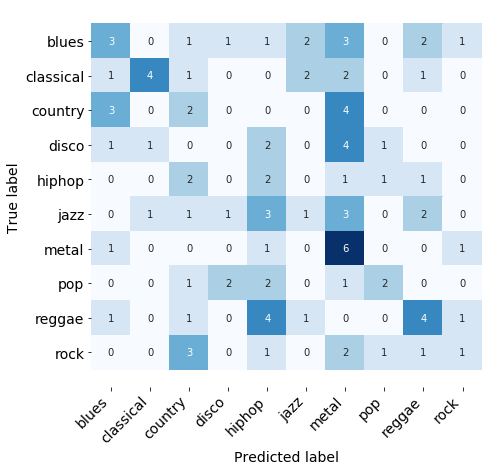

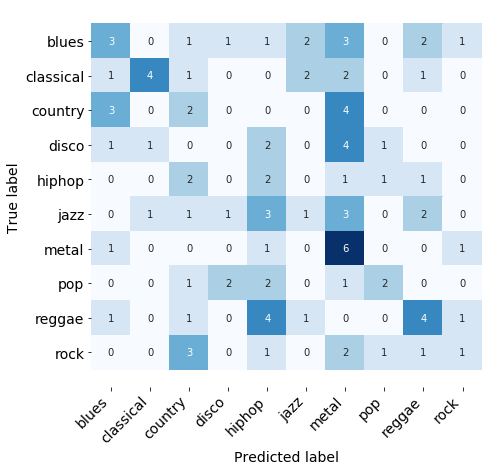

In [16]:
print_confusion_matrix(model=model2, test_dataX=test_files, test_dataY=test_labels, class_names=label_dict)

In [17]:
pred = np.argmax(predY, axis=-1)
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels.argmax(axis=1)[:len(pred)], y_pred=pred)))
print('Test Set F1-score =  {0:.2f}'.format(f1_score(y_true=test_labels.argmax(axis=1)[:len(pred)], y_pred=pred, average='macro')))

Test Set Accuracy =  0.25
Test Set F1-score =  0.23


## Tranfer Learning approach

In [5]:
VGG16 = tf.contrib.keras.applications.VGG16(include_top = False, 
                                            weights = 'imagenet', 
                                            input_shape = (img_width, img_height, 3))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0     

In [7]:
L2_LAMBDA = 0.001
model_transfer = models.Sequential()
model_transfer.add(VGG16)
model_transfer.add(layers.Flatten()) 

# 1-layer MLP with Dropout, BN
model_transfer.add(layers.Dropout(rate=0.2)) # Can try varying dropout rates
model_transfer.add(layers.Dense(512, kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model_transfer.add(layers.Dropout(rate=0.4)) # Can try varying dropout rates

model_transfer.add(layers.Dense(10, activation='softmax'))
VGG16.trainable = False
print(model_transfer.summary())
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 17,079,626
Trainable params: 2,364,938
Non-trainable params: 14,714,688
____________________________________

In [8]:
history = model_transfer.fit(train_files, train_labels, batch_size=4, epochs=20, verbose=1, validation_data=(test_files, test_labels))

Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - 11s 13ms/sample - loss: 127.3200 - acc: 0.3367 - val_loss: 95.5271 - val_acc: 0.4100
Epoch 2/20
900/900 [==============================] - 11s 12ms/sample - loss: 80.1409 - acc: 0.5222 - val_loss: 68.0760 - val_acc: 0.5100
Epoch 3/20
900/900 [==============================] - 11s 12ms/sample - loss: 61.0338 - acc: 0.6144 - val_loss: 78.6923 - val_acc: 0.5200
Epoch 4/20
900/900 [==============================] - 11s 12ms/sample - loss: 47.6246 - acc: 0.6767 - val_loss: 85.6914 - val_acc: 0.5800
Epoch 5/20
900/900 [==============================] - 11s 12ms/sample - loss: 34.9385 - acc: 0.7189 - val_loss: 96.4106 - val_acc: 0.5000
Epoch 6/20
900/900 [==============================] - 11s 12ms/sample - loss: 27.6016 - acc: 0.7567 - val_loss: 91.1830 - val_acc: 0.5300
Epoch 7/20
900/900 [==============================] - 11s 12ms/sample - loss: 31.2632 - acc: 0.7389 - val_loss: 93.3638 - val

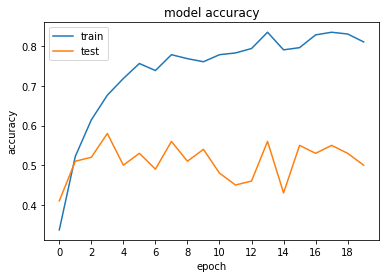

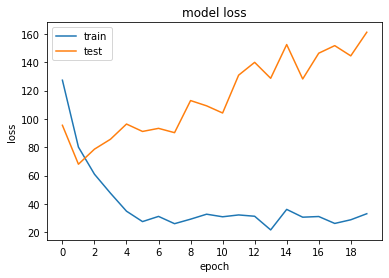

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(0, 20, step=2))
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0, 20, step=2))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
model_name = 'transfer_20epoch_59acc_final'

model_transfer.save(model_name + '.h5')  # creates a HDF5 file 'my_model.h5'
# del model_transfer  # deletes the existing model

# save model history
# history_dict = model_transfer.history
# json.dump(history_dict, open(model_name, 'w'))

# returns a compiled model
# identical to the previous one
model = load_model(model_name + '.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [15]:
# Create confusion matrix

# predict on test files
predY= model_transfer.predict(test_files)
# create actual confusion matrix
matrix = confusion_matrix(test_labels.argmax(axis=1), predY.argmax(axis=1))
print(matrix)

[[ 6  1  1  1  0  0  1  0  0  4]
 [ 0 10  0  0  0  1  0  0  0  0]
 [ 0  0  6  0  0  0  1  0  0  2]
 [ 0  0  2  3  0  0  0  1  2  1]
 [ 0  0  1  2  0  0  1  0  3  0]
 [ 1  2  0  4  0  3  1  0  1  0]
 [ 0  0  0  0  0  0  6  0  0  3]
 [ 0  0  1  2  0  0  0  4  1  0]
 [ 0  0  1  1  0  1  0  0  7  2]
 [ 0  0  1  1  0  0  0  0  2  5]]


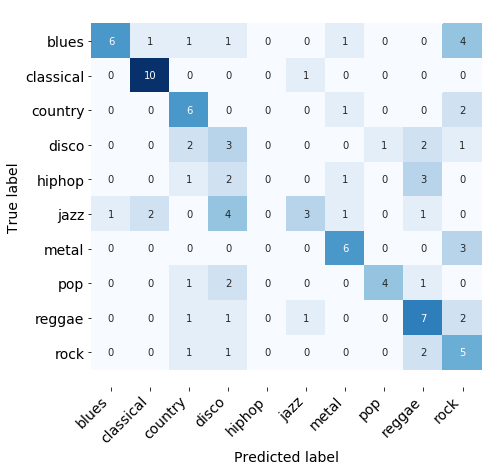

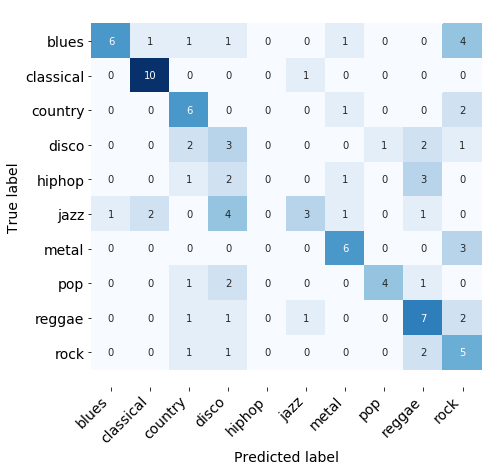

In [18]:
print_confusion_matrix(model=model_transfer, test_dataX=test_files, test_dataY=test_labels, class_names=label_dict)

In [20]:
pred = np.argmax(predY, axis=-1)
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels.argmax(axis=1)[:len(pred)], y_pred=pred)))
print('Test Set F1-score =  {0:.2f}'.format(f1_score(y_true=test_labels.argmax(axis=1)[:len(pred)], y_pred=pred, average='macro')))

Test Set Accuracy =  0.50
Test Set F1-score =  0.47
